# Carry Trade Analysis


In [8]:
import os
import datetime
import quandl
import random

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import numpy as np
import scipy as sp
import quandl
from sklearn.linear_model import LinearRegression



In [9]:
API_key_VX = "stqXZAdv9-_Dd2ZKAYFp"

In [10]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(os.environ["HOMEPATH"], "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink

    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=API_key_VX, **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )




In [4]:
path = '../data/Liq5YCDS.delim'
df = pd.read_csv(path, sep='\t').drop(columns=['Unnamed: 0'])

df.head()

,date,ticker,tenor,parspread,upfront,runningcoupon,cdsrealrecovery,cdsassumedrecovery,docclause,currency,tier,impliedrating
0,2018-01-01,BA,5Y,0.001793,-0.228583,0.05,0.40,0.4,MR14,USD,SNRFOR,BBB
1,2018-01-01,C,5Y,0.004113,-0.215978,0.05,0.40,0.4,MR14,USD,SNRFOR,A
2,2018-01-01,DD,5Y,0.002476,-0.225110,0.05,0.40,0.4,MR14,USD,SNRFOR,A
3,2018-01-01,F,5Y,0.008805,-0.005587,0.01,0.39,0.4,MR14,USD,SNRFOR,BB
4,2018-01-01,GE,5Y,0.004037,-0.028103,0.01,0.40,0.4,MR14,USD,SNRFOR,BBB


In [6]:
df.ticker.unique()

array(['BA', 'C', 'DD', 'F', 'GE', 'JPM', 'LNC', 'LOW', 'LUV', 'MAR', 'T',
       'WFC', 'WHR', 'XOM', 'XRX', 'NFLX'], dtype=object)

In [38]:
data = fetch_quandl_table("QUOTEMEDIA/PRICES", avoid_download=False)

Data file \Users\vince\quandl_data_table_downloads\QUOTEMEDIA/PRICES_20250219.zip size 1672923350 exists already, no need to download


In [58]:
ticker_set = set(df.ticker.unique())
ticker_set.add('SPY')

In [52]:
eq_price_data = data[data.ticker.isin(ticker_set)][['ticker', 'date', 'adj_close']]

In [53]:
eq_price_data.head()

,ticker,date,adj_close
246245,JPM,2023-06-05,133.946756
246754,NFLX,2023-06-05,403.540000
256453,JPM,2023-04-11,123.767611
292489,BA,2023-06-05,208.780000
300146,NFLX,2022-03-02,380.030000


In [54]:
time_span_df = df.groupby('ticker')['date'].agg(['min', 'max'])

time_span_df

,min,max
ticker,,
BA,2018-01-01,2024-12-31
C,2018-01-01,2024-12-31
DD,2018-01-01,2023-02-03
F,2018-01-01,2024-12-31
GE,2018-01-01,2024-12-31
JPM,2018-01-01,2024-12-31
LNC,2018-01-01,2024-12-31
LOW,2018-01-01,2024-12-31
LUV,2018-01-01,2024-12-31


In [64]:
ts_df = eq_price_data.groupby('ticker')['date'].agg(['min', 'max'])

ts_df

,min,max
ticker,,
BA,1962-01-03,2025-02-12
C,1977-01-05,2025-02-12
F,1972-06-07,2025-02-12
GE,1962-01-03,2025-02-12
JPM,1984-01-04,2025-02-12
LNC,1984-10-10,2025-02-12
LOW,1985-07-03,2025-02-12
LUV,1980-01-02,2025-02-12
MAR,1993-10-13,2025-02-12


We will remove DD from the dataset due to the lack of data. NFLX is also bad in the dataset, missing lots of returns.

In [ ]:
#ticker_set.remove('DD')
ticker_set.remove('NFLX')

eq_price_data = eq_price_data[eq_price_data.ticker.isin(ticker_set)]
cds_df = df[df.ticker.isin(ticker_set)]

KeyError: 'NFLX'

# Initial Construction

Need to grab equity returns, ETF returns, CDS spread 'returns' and market returns. We will only look for Wednesday data.

In [155]:
cds_df['date'] = pd.to_datetime(cds_df['date'])
eq_price_data['date'] = pd.to_datetime(eq_price_data['date'])

cds_df = cds_df[['ticker', 'date', 'parspread']]

cds_df = cds_df[cds_df.date.dt.weekday == 2]
eq_price_data = eq_price_data[eq_price_data.date.dt.weekday == 2]

min_filter = eq_price_data.date >= '2018-01-01'
max_filter = eq_price_data.date <= '2024-12-31'

eq_price_data = eq_price_data[min_filter & max_filter]

In [156]:
eq_price_data['return'] = eq_price_data.sort_values(by=['ticker', 'date']).groupby('ticker')['adj_close'].pct_change().dropna()
cds_df['return'] = cds_df.sort_values(by=['ticker', 'date']).groupby('ticker')['parspread'].pct_change().dropna()

In [157]:
cds_df.dropna(inplace=True)
eq_price_data.dropna(inplace=True)

# Process OLS:

Need boxcar regressions and half life exponentially decaying regression.

In [158]:
eq_ret_df = eq_price_data.pivot(index='date', columns='ticker', values='return')
cds_ret_df = cds_df.pivot(index='date', columns='ticker', values='return')


In [159]:
cds_ret_df['index'] = cds_ret_df.apply(lambda row: row.mean(), axis=1)

In [173]:
def lin_regressions(X, y):
    X_np = X.to_numpy()
    y_np = y.to_numpy()

    if len(X_np.shape) == 1:
        X_np = X_np.reshape(-1, 1)

    beta = np.linalg.inv(X_np.T @ X_np) @ X_np.T @ y_np
    return beta.flatten()

In [220]:
def exp_decay_regression(X, y, H, min_obs=2):
    """
    Perform an exponentially weighted least squares regression.

    Parameters:
    X (pd.DataFrame or np.ndarray): Independent variables (features)
    y (pd.Series or np.ndarray): Dependent variable (target)
    H (float): Half-life for exponential weighting
    min_obs (int): Minimum number of observations required to perform regression

    Returns:
    np.ndarray: Estimated regression coefficients or NaN if not enough data
    """
    n = len(y)
    
    # Ensure we have enough observations
    if n < min_obs:
        return np.full((X.shape[1],), np.nan)  # Return NaN for each coefficient if too little data

    # Convert to NumPy arrays
    X_np = np.asarray(X)
    y_np = np.asarray(y).reshape(-1, 1)  # Ensure y is a column vector

    # Ensure X_np is at least 2D
    if X_np.ndim == 1:
        X_np = X_np.reshape(-1, 1)

    # Compute exponential decay weights
    weights = np.exp(-np.log(2) * np.arange(n)[::-1] / H)
    W = np.diag(weights)

    # Compute weighted matrices
    XTWX = X_np.T @ W @ X_np  # X'WX
    XTWY = X_np.T @ W @ y_np  # X'Wy

    # Ensure XTWX is at least 2D
    if XTWX.ndim == 0:
        return np.full((X.shape[1],), np.nan)  # Return NaN if XTWX is singular

    # Solve for beta using pseudo-inverse (handles singularity)
    beta = np.linalg.pinv(XTWX) @ XTWY  

    return beta.flatten()


In [162]:
eq_set = ticker_set.copy()
eq_set.remove('SPY')

In [165]:
common_ind = eq_ret_df.index.intersection(cds_ret_df.index)

eq_ret_df = eq_ret_df.loc[common_ind]
cds_ret_df = cds_ret_df.loc[common_ind]

# Creating function that processes the data given a choice of running data on contemporaneous model.

In [223]:
def add_all_models(eq_df, cds_df, factor, exp=False):
    '''
    eq_df: equity dataframe 
    cds_df: cds dataframe
    exp: indicator of whether or not we are using exponential decay
    factor: the value which H or G is depending on whether we choose exponential decay or not

    will return a combined df with contemporaneous factors
    '''
    e_df = eq_df.copy()
    c_df = cds_df.copy()
    # use factor as the boxcar window
    num_rows = len(e_df.index)

    for eq_name in eq_set:
        name1 = f'{eq_name} lambda'
        name2 = f'{eq_name} equity beta'
        name3 = f'{eq_name} cds index beta'

        l_list = [np.nan] * factor  # Initialize with NaNs for the first `factor` rows
        index_beta_list = [np.nan] * factor
        eq_beta_list = [np.nan] * factor

        if exp:
            # will implement a minimal window for the regression
            # size will be factors
            for i in range(num_rows - factor):
                X_e_box = e_df[eq_name].iloc[:i + factor]  # Select a window of `factor` rows
                y_e_box = e_df['SPY'].iloc[:i + factor]  # Same for y

                X_c_box = c_df['index'].iloc[:i + factor]
                y_c_box = c_df[eq_name].iloc[:i + factor]

                X_eq_ind = pd.DataFrame({
                    eq_name: X_e_box,
                    'index': X_c_box
                })

                lmba = exp_decay_regression(X_e_box, y_e_box, factor)
                betas_cont = exp_decay_regression(X_eq_ind, y_c_box, factor)

                l_list.append(lmba[0])
                eq_beta_list.append(betas_cont[0])
                index_beta_list.append(betas_cont[1])

        else:
            for i in range(num_rows - factor):
                X_e_box = e_df[eq_name].iloc[i:i + factor]  # Select a window of `factor` rows
                y_e_box = e_df['SPY'].iloc[i:i + factor]  # Same for y

                X_c_box = c_df['index'].iloc[i:i + factor]
                y_c_box = c_df[eq_name].iloc[i:i + factor]

                X_eq_ind = pd.DataFrame({
                    eq_name: X_e_box,
                    'index': X_c_box
                })
                lmba = lin_regressions(X_e_box, y_e_box)
                betas_cont = lin_regressions(X_eq_ind, y_c_box)

                l_list.append(lmba[0])
                eq_beta_list.append(betas_cont[0])
                index_beta_list.append(betas_cont[1])

        e_df[name1] = l_list
        e_df[name2] = eq_beta_list
        e_df[name3] = index_beta_list

    for eq_name in eq_set:
        e_df = e_df.rename(columns={
            eq_name: f'{eq_name} eq'
        })
        c_df = c_df.rename(columns={
            eq_name: f'{eq_name} cds'
        })


    comb_df = pd.merge(e_df, c_df, left_index=True, right_index=True)

    for eq_name in eq_set:
        f_name = f'{eq_name} f'
        rho_name = f'{eq_name} rho'
        c_name = f'{eq_name} c'
        c_shift = f'{c_name} shift'
        equity_name = f'{eq_name} eq'
        cds_name = f'{eq_name} cds'

        lbda_name = f'{eq_name} lambda'
        eq_beta_name = f'{eq_name} equity beta'
        ind_beta_name = f'{cds_name} index beta'

        mu_name = f'{eq_name} mu'
        q_name = f'{eq_name} q'

        comb_df[f_name] = comb_df[equity_name] * comb_df[eq_beta_name] + comb_df['index'] * comb_df[ind_beta_name]
        comb_df[rho_name] = comb_df[cds_name] - comb_df[f_name]

        comb_df[c_name] = comb_df[equity_name] - comb_df[lbda_name] * comb_df['SPY']
        comb_df[c_shift] = comb_df[c_name].shift()

        # do the rho vs c regression
        # REDO THIS: IT IS A G WINDOW REGRESSION AND THE H FACTOR
        # c shift should have factor + 1 NaNs
        # a rolling regression winow of size factor should have 5 values, including the 
        # one specified
        # If factor = 5, we will use n-4 to n as n

        mu_list = (2 * factor) * [np.nan]


        if exp:
            for i in range(factor + 1, num_rows - factor + 1):
                X_box = comb_df[c_shift].iloc[factor + 1:i + factor]
                y_box = comb_df[rho_name].iloc[factor + 1:i + factor]

                mu = exp_decay_regression(X_box, y_box, factor)
                mu_list.append(mu[0])
            

        else:
            

            for i in range((factor + 1),(num_rows - factor + 1)):
                X_box = comb_df[c_shift].iloc[i:i + factor]
                y_box = comb_df[rho_name].iloc[i:i + factor]

                mu = lin_regressions(X_box, y_box)
                mu_list.append(mu[0])

        comb_df[mu_name] = mu_list

        comb_df[q_name] = comb_df[rho_name] - comb_df[c_shift] * comb_df[mu_name]
        
    return comb_df




In [225]:
add_all_models(eq_ret_df, cds_ret_df, factor=5).head(15)

ticker,BA eq,C eq,F eq,GE eq,JPM eq,LNC eq,LOW eq,LUV eq,MAR eq,SPY,...,MAR c,MAR c shift,MAR mu,MAR q,C f,C rho,C c,C c shift,C mu,C q
date,,,,,,,,,,,,,,,,,,,,,
2018-01-24,-0.046494,0.025558,-0.010673,-0.052450,0.023719,0.004338,0.053585,-0.058423,0.016831,0.012768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-31,0.058801,-0.012209,-0.066703,-0.016423,0.000000,-0.006479,-0.018647,-0.022665,0.020431,-0.004520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-07,-0.017637,-0.040500,-0.019143,-0.056895,-0.024207,-0.051812,-0.045928,-0.047862,-0.052260,-0.050479,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-14,-0.004255,0.022936,-0.001859,-0.022951,0.019137,-0.015412,-0.029924,-0.002764,0.040103,0.007173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-21,0.021807,0.003780,-0.013035,-0.027517,0.001391,0.013195,-0.016404,0.005197,-0.022583,0.001706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-28,0.027925,-0.019610,0.000943,-0.018161,0.002691,-0.027451,-0.060310,-0.003274,-0.002948,0.005925,...,-0.006161,NaN,NaN,NaN,0.012882,-0.040938,-0.024768,NaN,NaN,NaN
2018-03-07,-0.041882,-0.020797,0.001885,0.028349,-0.006667,-0.001707,-0.038844,-0.002532,-0.015792,0.004160,...,-0.017982,-0.006161,NaN,NaN,0.028169,0.004875,-0.024099,-0.024768,NaN,NaN
2018-03-14,-0.048352,-0.006088,0.036689,-0.016540,0.001918,0.003025,0.003136,0.035609,0.017628,0.009238,...,0.012557,-0.017982,NaN,NaN,-0.035472,-0.018963,-0.012290,-0.024099,NaN,NaN
2018-03-21,0.020711,-0.002042,0.007260,-0.027330,-0.001827,0.012194,0.010072,-0.030862,-0.007141,-0.013761,...,-0.005457,0.012557,NaN,NaN,0.141524,-0.030722,-0.002910,-0.012290,NaN,NaN


# Strategy implementation

We will be short if q is relatively high, we will be long if q is relatively low.

To prevent look forward bias and a reliable sample for trading, we will use an initial sample of 60 weeks for our trading strategy. 

In [261]:
def process_model_ret(eq_df, cds_df, percentile, factor, exp=False):
    df = add_all_models(eq_df, cds_df, factor=5, exp=exp)

    num_rows = len(df.index)

    init_sample = 60
    nan_sample = 2 * factor
    pnl_rows = []

    # will just recieve log rho as PnL, will not scale our position based upon attractiveness
    for eq_name in eq_set:
        q_name = f'{eq_name} q'
        rho_name = f'{eq_name} rho'
        pnl_name = f'{eq_name} pnl'
        pnl_rows.append(pnl_name)
        
        pnl_list = (init_sample + nan_sample) * [np.nan]

        for i in range(init_sample + nan_sample, num_rows):
            q_ser = df[q_name].iloc[nan_sample: i - 1]
            top_val = q_ser.quantile(1 - percentile)
            bottom_val = q_ser.quantile(percentile)

            if df[q_name].iloc[i] > top_val:
                # should be shorting rho if above because over-valued
                pnl_list.append(np.log(1 + df[rho_name].iloc[i]))
            elif df[q_name].iloc[i] < bottom_val:
                # long rho here
                pnl_list.append(np.log(1 - df[rho_name].iloc[i]))
            else:
                pnl_list.append(0)

        df[pnl_name] = pnl_list

    df['all eq pnl'] = df[pnl_rows].sum(axis=1)
    df['total pnl'] = df['all eq pnl'].cumsum()

    return df




        


# Model Trial

We will try 18 different models, variation of H and G from the set [10, 20, 30] and quantile thresholds of [0.01, 0.05, and 0.10]. 

We will do some more in depth analysis with our best model.

In [264]:
mp_list = []
f_list = [10, 20, 30]
exp_list = [True, False]
p_list = [0.01, 0.05, 0.10]

for f in f_list:
    for e in exp_list:
        for p in p_list:
            mp_list.append((f, e, p))

In [267]:
def graph_elements(cols_to_graph, eq_df, cds_df, mp_list):
    # select the column we want to graph vs date
    # model_params_list is a list of tuples in form (factor, exp, percentile)

    fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(9, 18))
    fig.tight_layout(pad=3.0) 
    ax_arr = axes.flat

    for i in range(18):  # Iterate over all axes
        factor, exp, percentile = mp_list[i]
        ax = ax_arr[i]
        df = process_model_ret(eq_df, cds_df, percentile, factor, exp=exp)

        x = df.index
        y = df[cols_to_graph]
        ax.plot(x, y)

        model_name = 'Exp Decay with half life' if exp else 'Box Car with window'
        
        name = f'{percentile} threshold, {model_name} {factor}'
        ax.set_title(name)
        ax.legend()



C:\Users\vince\AppData\Local\Temp\ipykernel_19796\3937456794.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['all eq pnl'] = df[pnl_rows].sum(axis=1)
C:\Users\vince\AppData\Local\Temp\ipykernel_19796\3937456794.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['total pnl'] = df['all eq pnl'].cumsum()
C:\Users\vince\AppData\Local\Temp\ipykernel_19796\781910265.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called

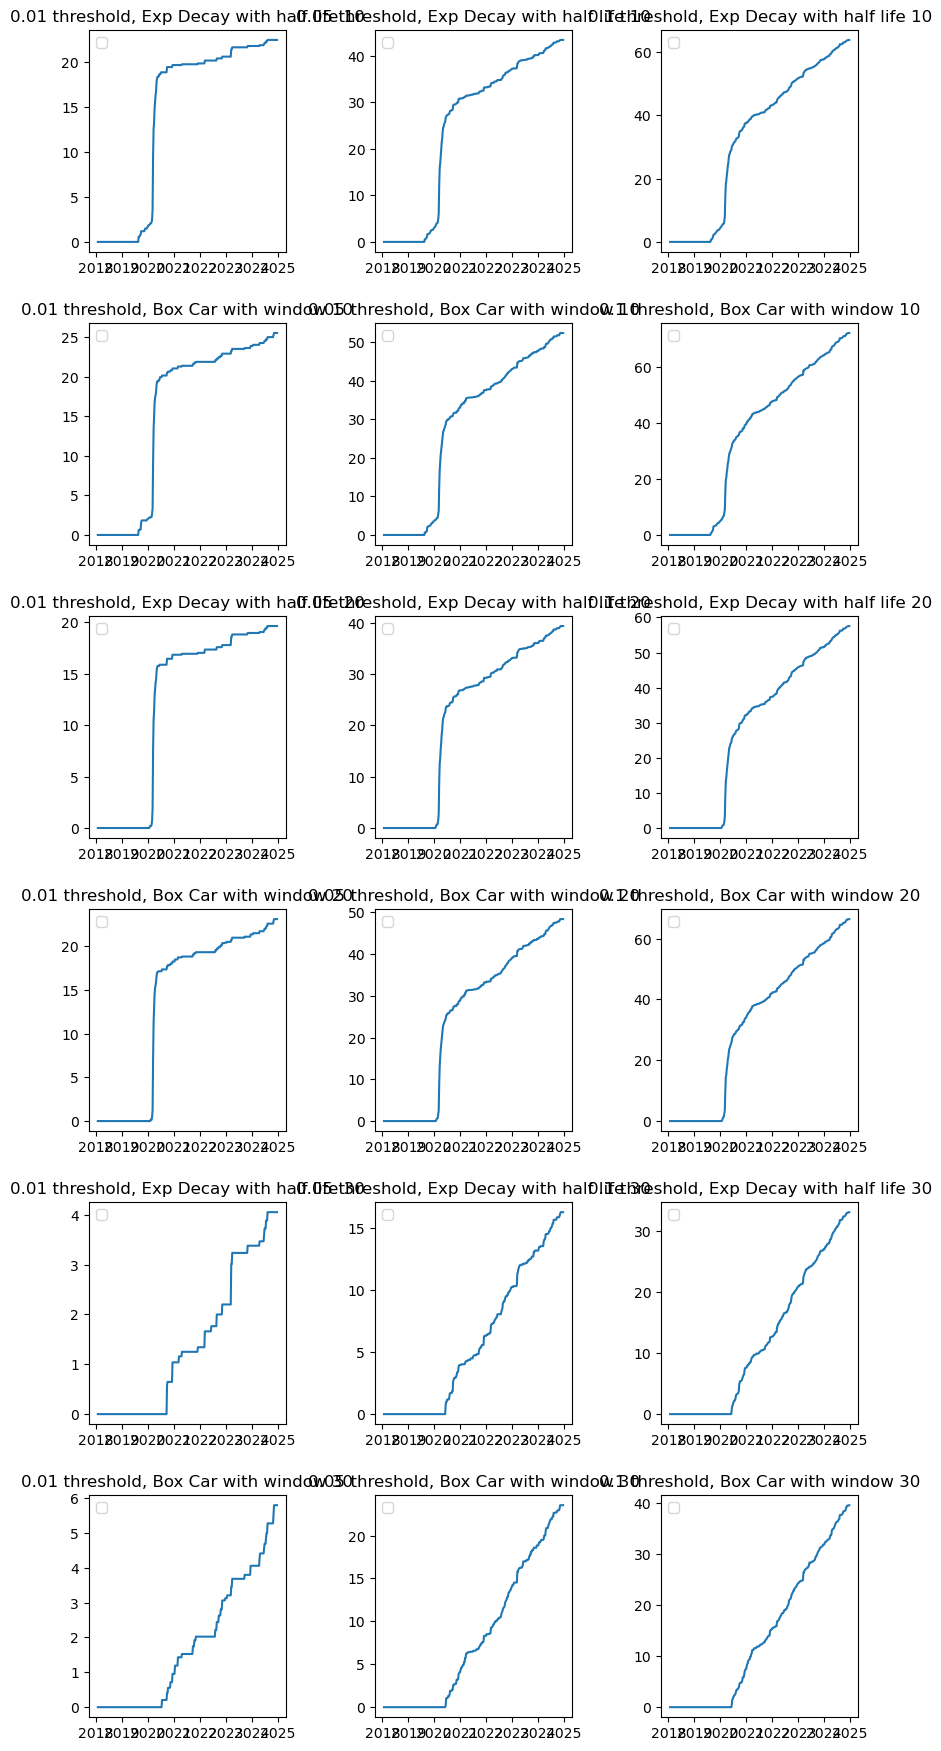

In [268]:
graph_elements('total pnl', eq_ret_df, cds_ret_df, mp_list)

# Observations

We see that the box-car model seems to consistently out-perform the half life models with the same parameters.

The best model we see is the boxcar with window 10 and percentile threshold of 0.10. Let's observe this model closely.

factor = 10

exp = False

percentile = 0.10



In [269]:
fin_df = process_model_ret(eq_ret_df, cds_ret_df, 0.10, factor=10)

C:\Users\vince\AppData\Local\Temp\ipykernel_19796\3937456794.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['all eq pnl'] = df[pnl_rows].sum(axis=1)
C:\Users\vince\AppData\Local\Temp\ipykernel_19796\3937456794.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['total pnl'] = df['all eq pnl'].cumsum()


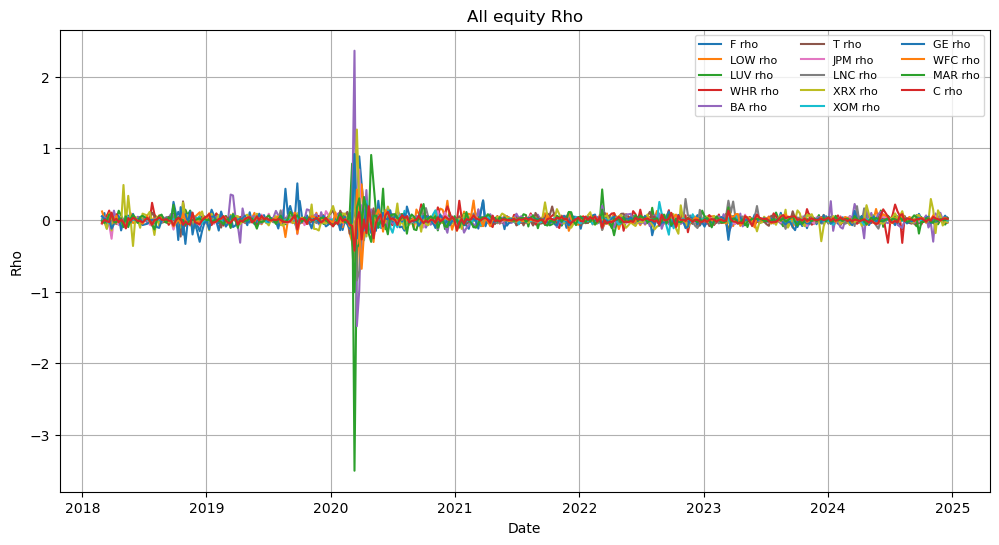

In [270]:
plt.figure(figsize=(12, 6))

for eq_name in eq_set:
    col_name = f'{eq_name} rho'
    y = fin_df[col_name]
    plt.plot(fin_df.index, y, label=col_name)

plt.xlabel("Date")
plt.ylabel("Rho")
plt.title("All equity Rho")
plt.legend(ncol=3, fontsize=8, loc="upper right")  # Adjust legend size for clarity
plt.grid(True)

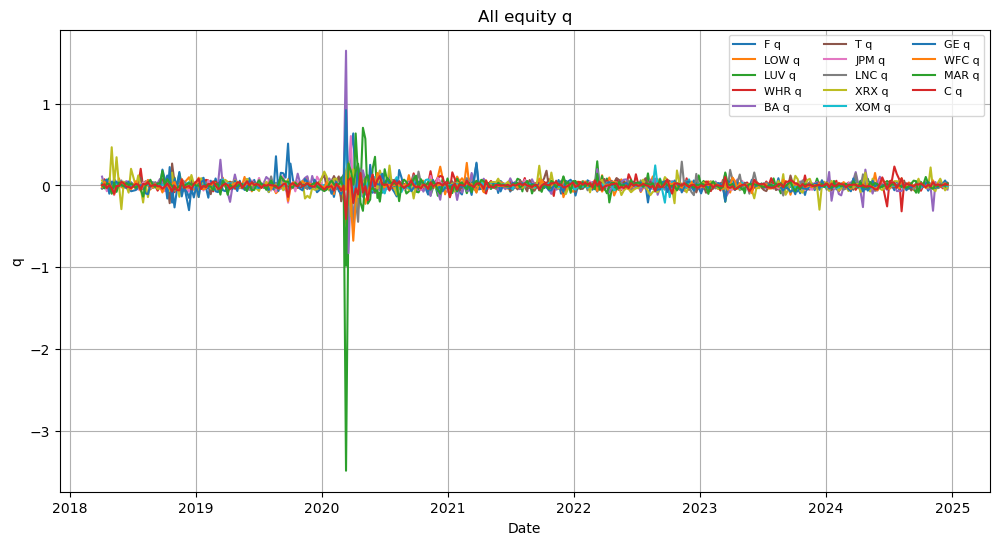

In [272]:
plt.figure(figsize=(12, 6))

for eq_name in eq_set:
    col_name = f'{eq_name} q'
    y = fin_df[col_name]
    plt.plot(fin_df.index, y, label=col_name)

plt.xlabel("Date")
plt.ylabel("q")
plt.title("All equity q")
plt.legend(ncol=3, fontsize=8, loc="upper right")  # Adjust legend size for clarity
plt.grid(True)

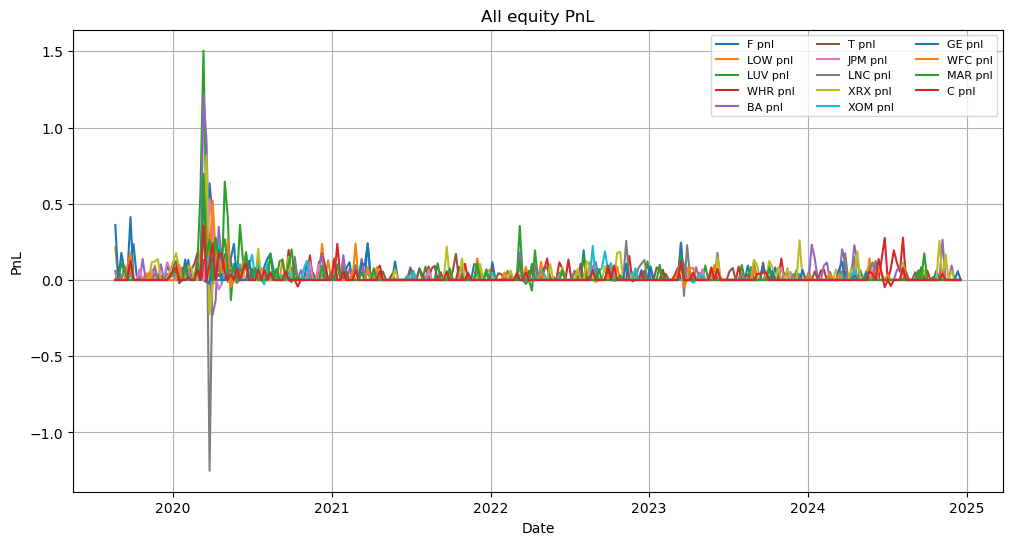

In [273]:
plt.figure(figsize=(12, 6))

for eq_name in eq_set:
    col_name = f'{eq_name} pnl'
    y = fin_df[col_name]
    plt.plot(fin_df.index, y, label=col_name)

plt.xlabel("Date")
plt.ylabel("PnL")
plt.title("All equity PnL")
plt.legend(ncol=3, fontsize=8, loc="upper right")  # Adjust legend size for clarity
plt.grid(True)

In [280]:
def graph_signal(df):
    # select the column we want to graph vs date
    # model_params_list is a list of tuples in form (factor, exp, percentile)

    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(9, 18))
    fig.tight_layout(pad=3.0) 
    ax_arr = axes.flat
    eq_list = list(eq_set)

    for i in range(14):  # Iterate over all axes
        factor, exp, percentile = mp_list[i]
        ax = ax_arr[i]
        eq_name = eq_list[i]

        q_name = f'{eq_name} q'
        rho_name = f'{eq_name} rho'

        x = df[q_name].shift(-1)
        y = df[rho_name]
        ax.scatter(x, y)

        name = f'rho vs q signal for {eq_name}'
        ax.set_title(name)



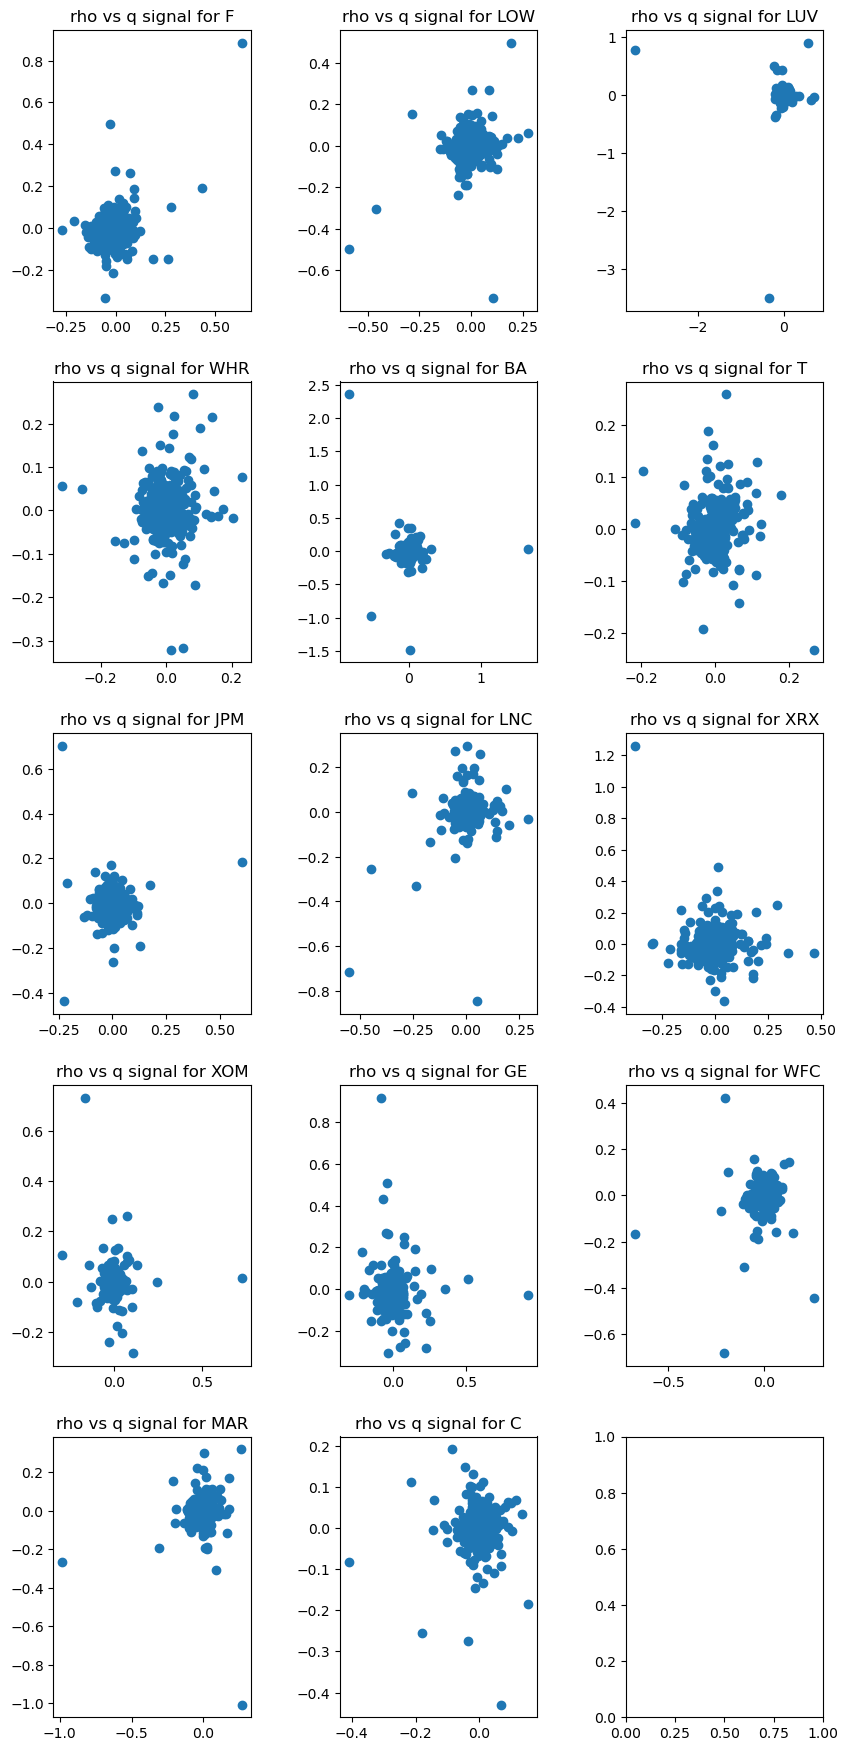

In [281]:
graph_signal(fin_df)

# Final Analysis

We see in our rho graph and our q graph that the q value is a relatively consistent signal. However, for lagged regressions this may not be as sure of a thing. 

We see that the q signal in the 10th quantile consistently makes us returns. However, we also see that there is a relatively large draw down in BA around the start of 2020 from the signal we generated. 

This is interesting as we see a spike in q that is in line with the spike in P to the positive side. Seems that our lagged signal may not be as consistent as we thought it would be. 

In the above graphs, we also see a sensitivity analysis of q as a signal to rho. This has yielded interesting results. We see the outlier in BA in the top left corner of its graph and many signals near the origin. These are not in the top 10% so could potentially be ignored. 

In the future, we should include more stocks into our dataset to address a wider array of signals and any potential for correlations between PnLs due to similar industry, credit profile, cap structure, and more.